<a href="https://colab.research.google.com/github/Nick7900/glhmm_protocols/blob/main/Procedures/Procedure_1_Across_subject_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procedure 1: Across-Subject Testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)
In this tutorial, we demonstrate how to implement the Across-subjects test using the [GLHMM toolbox](https://github.com/vidaurre/glhmm). Details about the HMM and the different models can be found in the paper [The Gaussian-Linear Hidden Markov Model: a Python Package](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python). The test is designed to explore relationships between brain states, as identified by Hidden Markov Models, and behavioural traits across individuals, i.e. for studying individual differences.

For this tutorial, we use data from the Human Connectome Project (HCP) S1200 Young Adult dataset ([van Essen et al., 2013](https://pmc.ncbi.nlm.nih.gov/articles/PMC3724347/)), and will anlyse the relationship between **brain data** and **behavioural measurement** during resting-state recordings.
* Brain activity measurements, captured during resting-state fMRI sessions.
* Behavioural information, such as cognitive traits and performance

---

### Objective of this Procedure  

The key question we aim to answer is:  
**"Do differences in brain states explain variability in behavioural traits across individuals?"**  

To address this, we will:  
* Estimate brain states: Train a Hidden Markov (HMM) model to decode brain states from the fMRI data for each subject.
* Test relationships: Perform permutation testing between brain states ($D$ matrix) and behavioural traits ($R$ matrix).

---
### Accessing the Data 

**Access to HCP data requires permission. If you have not yet applied for access, follow the instructions [here](https://db.humanconnectome.org/) to request permission and download the data (ICA time series).**

---


### Structure of the Procedure
The steps in this tutorial follow the workflow shown in the figure below:

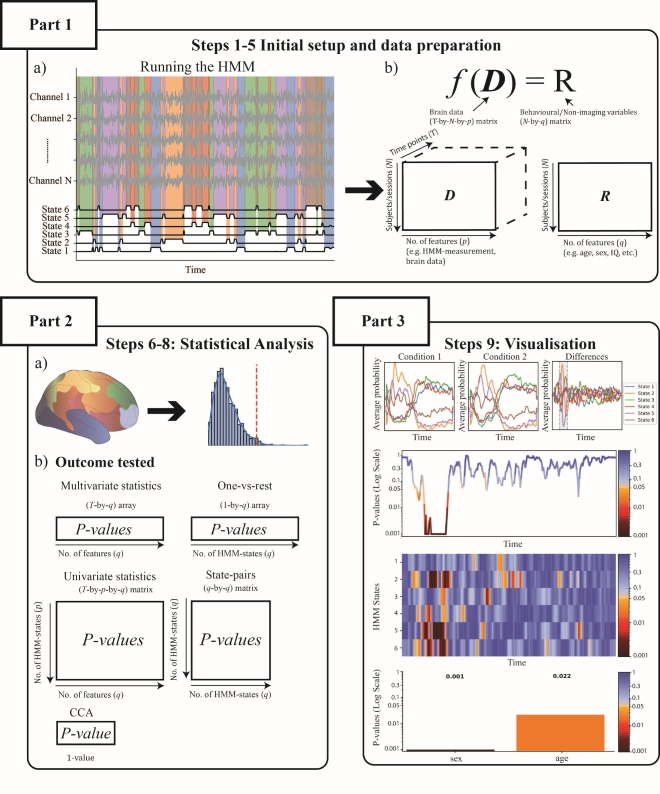

## Table of Contents
* [Part 1. Load and prepare data](#load-data)
    * [Step 1. Load data into Python environment](#prep_env)
    * [Step 2. Data structuring for HMM Training](#data_shape)
    * [Step 3. Preprocessing data](#preprocess_data)
    * [Step 4. Set-up and train HMM](#data_handle2)
    * [Step 5. Configure HMM outputs for statistical analysis](#data_handle)
* [Part 2 & 3. Statistical Analysis and Visualisation](#stat_analysis)
    * [Step 6. Types of test - Across subject test](#stat_test)
        * [Family Structure](#fam_struc)
    * [Step 7. Multivariate test](#perm_multivariate)
        * [Step 8. Multiple comparison test - Multivariate](#multi_corr)
        * [Step 9. P-value plots - Multivariate](#multi_vis)
    * [Step 7. Univariate test](#perm_univariate)
        * [Step 8. Multiple comparison test - Univariate](#uni_corr)
        * [Step 9. P-value plots - Univariate](#uni_vis)
<a id="vis"></a>

### Install necessary packages
If you dont have the **GLHMM-package** installed or using **Google Colab**, then run the following command in your terminal:

```pip install git+https://github.com/vidaurre/glhmm```

### Import libraries
Let's start by importing the required libraries and modules.

In [1]:
# Install the GLHMM_package when using Google Colab
try:
    import google.colab
    IN_COLAB = True
    !pip install git+https://github.com/vidaurre/glhmm
except ImportError:
    IN_COLAB = False

# Import libraries
import numpy as np
from glhmm import io,glhmm, graphics, statistics, preproc
from pathlib import Path
import pickle

## Part 1 - Initial setup and data preparation <a id="load-data"></a>
### 1. Load data into Python environment <a id="prep_env"></a>
To begin the analysis, we load data from the HCP dataset into Python.\
The analysis uses three inputs: **brain data**, **behavioural measurements**, and **confounding variables**, referred to as ```D_raw```, ```R_data```, and ```confounds_data```, respectively.\
**Remember** that the HCP data is not shared in the Zenodo folder.


In [2]:
# Get the current directory
PATH_WORKING = Path.cwd()
PATH_DATA = PATH_WORKING / "data" / "Procedure_1_data"
PATH_FIGURES = PATH_DATA / "figures"

# If the required data for the protocol paper is missing, this function downloads it from Zenodo.
io.prepare_data_directory(PATH_DATA)

# Load resting state fMRI data
D_raw = np.load(PATH_DATA / "data_measurement_HCP.npy")

# Load behavioural data
R_data = np.load(PATH_DATA / "data_cognitive_traits_HCP.npy")

# Load confounds
confounds_data = np.load(PATH_DATA / "confounds_HCP.npy") #sex, age, rfMRI_motion

print(f"Shape of D_data: {D_raw.shape}")
print(f"Shape of R_data: {R_data.shape}")
print(f"Shape of confounds data: {confounds_data.shape}")

Shape of D_data: (4800, 1001, 50)
Shape of R_data: (1001, 15)
Shape of confounds data: (1001, 3)


#### Explore the Dataset

**Brain data (`D_raw`)**\
The brain data `(No. of timepoints, No. of subjects, No. of features)` is derived from the resting-state fMRI data.\
It has a shape of `[4800, 1001, 50]`:
* 4800: Total time points across four scanning sessions (~15 minutes each)
* 1001: Number of subjects
* 50: Independent components (ICs) derived from parcellation


**Behavioural measurements (`R_data`)**\
The behavioural data `(No. of subjects, No. of features)` is a 2D array with shape `(1001, 15)`:
* 1001: Number of subjects
* 15: Cognitive traits, including fluid intelligence (problem-solving and reasoning) and unadjusted test scores for memory, language, and processing speed

The behavioural data will be used to investigate if there is a link between the brain activity patterns and the cognitive traits.

**Confounding variables (`confounds_data`) (Optional)**\
The confounding variables `(No. of subjects, No. of confounds)` are a 2D array with shape `(1001, 3)`:
- 1001: Number of subjects
- 3: Confounds (sex, age, and fMRI motion)

These variables can be used to reduce bias by regressing out factors that are unrelated to the relationship between brain activity and cognition.

### 2. Data structuring for the HMM <a id="data_shape"></a>
When preparing and training an HMM (optional steps 2-5), the data needs to be structured as ```[(No. of subjects/sessions × No. of timepoints), No. of features]```. Here, the first dimension combines either subjects and/or sessions, while the second dimension represents features, such as parcels or channels.

For instance, a dataset with dimensions ```[4800, 1001, 50]``` (```[No. of timepoints, No. of subjects, No. of features]```) would be reshaped to ```[4804800, 50]```. This reshaping combines the timepoints and subjects into a single dimension.

The function ```get_concatenate_subjects``` will be used to perform this transformation and generate the concatenated data.

In [3]:
# Concatenate the data
D_con = statistics.get_concatenate_subjects(D_raw)

We can check that the shape of `D_con` is as expected, and that the stacking of the subjects is done correctly
(by checking that the timepoints for the first subject in the original data align with the first 4800 rows in the concatenated data). 


In [4]:
print(D_con.shape)
print(np.array_equal(D_raw[:, 0, :], D_con[0:4800, :]))

(4804800, 50)
True


Along with ```D_con```, we need an index matrix to indicate the start and end timepoints for each subject in the concatenated time series. This matrix should have the shape ```[No. of subjects, 2]```, where each row specifies the starting and ending timepoints for a subject.

Since each subject has 4800 timepoints, we can generate this index matrix using the `get_indices_timestamp` function:




In [5]:
#Generate indices of the timestamps for each subject in the data
idx_subject = statistics.get_indices_timestamp(D_raw.shape[0], D_raw.shape[1])

# Visualise the output for the session indices
print(f"Indices for each session:\n {idx_subject}")

Indices for each session:
 [[      0    4800]
 [   4800    9600]
 [   9600   14400]
 ...
 [4790400 4795200]
 [4795200 4800000]
 [4800000 4804800]]


### 3. Preprocessing data <a id="preprocess_data"></a>
Before we can train the HMM, we need to prepare the data so it is ready for analysis.
However, **preprocessing (step 3) and training the HMM (step 4) are optional**. If you prefer, you can skip these steps and use the pre-saved `Gamma` values provided for this tutorial (see **Step 4**).\
The `Gamma` values, obtained from the HMM, represent the probabilities of being in each brain state at every timepoint and are central to the subsequent analysis.

Standardising the timeseries is a key preprocessing step, especially when comparing individuals. It helps reduce random noise in the measurements.

Here, we standardise the signal using the `preprocess_data` function, where we set `standardise = True`:

Although we are only using standardisation in this example, the `preprocess_data` function includes many other preprocessing options that can be useful in different scenarios. These include:

* **Filtering**: Applies low-pass, high-pass, or band-pass filtering to remove unwanted frequency components.

* **Detrending**: Removes linear trends from the data to mitigate slow drifts.

* **Power and phase extraction**: Uses the Hilbert transform to extract power or phase information from the signal.

* **Dimensionality reduction**: Supports Principal Component Analysis (PCA) and Independent Component Analysis (ICA) to reduce data complexity while preserving important structure.

* **Post-standardisation**: Ensures the data remains standardised after PCA/ICA transformation, which is useful for certain HMM applications.

* **Downsampling**: Reduces the frequency of the data to optimise computational efficiency.




In [53]:
# Preprocess the data
D_preproc,_ = preproc.preprocess_data(
    D_con, 
    idx_subject, 
    standardise = True
)

To show the effect of the preprocessing we visualise the original and standardised timeseries. As an example we plot the data from the first participant. 

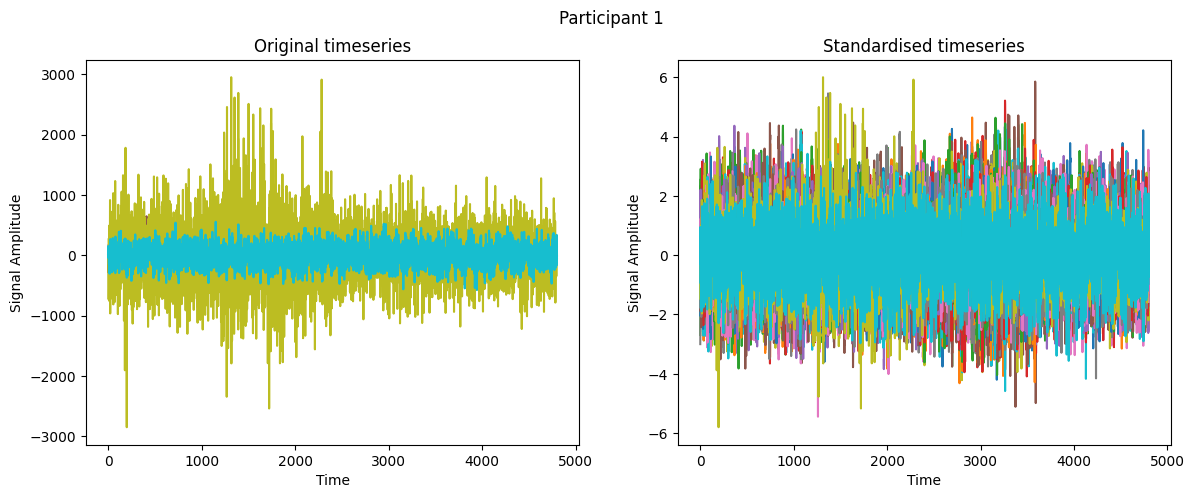

In [8]:
# Create subplots
fig, ax = plt.subplots(1,2, figsize=(14, 5))

# Plot original timeseries
ax[0].plot(D_con[0:4800, :])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal Amplitude")
ax[0].set_title("Original timeseries")

# Plot standardised timeseries
ax[1].plot(D_preproc[0:4800, :])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Signal Amplitude")
ax[1].set_title("Standardised timeseries")

fig.suptitle("Participant 1")

# Adjust layout
plt.subplots_adjust(hspace=0.5)

# Show plot
plt.show()


### Step 4. Set-up and train a HMM <a id="data_handle2"></a>
A HMM helps us find recurring patterns in brain activity over time. It identifies "states" in the data, i.e. periods of time during which the data show relatively stable properties. 

One of the main results of training the HMM is the state time courses, referred to as `Gamma`. This is the probability of each state to be active per timepoint. Gamma will be the focus of our subsequent analysis.

---
**Option 1: Skip Training with pre-saved `Gamma` values**\
Before training the HMM, you can choose to load pre-saved (`Gamma`) to skip the training process entirely. This lets you use the state time courses from this tutorial directly. To do so, use the following code:

```python
# Load pre-saved Gamma data
Gamma = np.load(PATH_DATA / "gamma_K12.npy")
print(f"Gamma shape: {Gamma.shape}")
```
---

**Option 2: Train the HMM**\
If you have preprocessed the data yourself, you can train the HMM to estimate `Gamma`. 

**Set up the model**\
For this tutorial, we use a standard Gaussian HMM. Here are the settings we use:
* `model_beta='no'`: No interaction modeling between variable sets.
* `K=12`: Number of brain states to identify (you can adjust this number as needed).
* `covtype='full'`: Each state uses a full covariance matrix.

(See the [GLHMM paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python) for details about all the possible models)

**Train the model**\
The preprocessed time series (```D_preproc```) is used as the input (```Y```), and the subject indices (```idx_subject```) marks beginning and end indices of each preprossed subject. Since this is a standard HMM without interactions between variable sets, we set ```X=None```.


In [9]:
# Set up the model
hmm_HCP = glhmm.glhmm(model_beta='no', K=12, covtype='full')

# Train the HMM
Gamma, _, _  = hmm_HCP.train(X=None, Y=D_preproc, indices=idx_subject)

Init repetition 1 free energy = 364667891.5342298
Init repetition 2 free energy = 364598075.1087418
Init repetition 3 free energy = 364371235.5562593
Init repetition 4 free energy = 364446610.1178802
Init repetition 5 free energy = 364442005.5197022
Best repetition: 3
Cycle 1 free energy = 364396763.2103793
Cycle 2 free energy = 364292388.16025114
Cycle 3, free energy = 364259941.44252896, relative change = 0.2371458740225378
Cycle 4, free energy = 364238626.04257137, relative change = 0.1347905761375819
Cycle 5, free energy = 364222992.11380494, relative change = 0.0899685222377521
Cycle 6, free energy = 364210962.5749447, relative change = 0.06474433648798762
Cycle 7, free energy = 364201472.4943945, relative change = 0.048594632378383976
Cycle 8, free energy = 364193950.6634909, relative change = 0.03708760142797424
Cycle 9, free energy = 364187971.08944726, relative change = 0.028638887410783943
Cycle 10, free energy = 364183163.00421125, relative change = 0.022509740614342147
Cycl

Once the HMM training is complete, it provides three outputs that summarise the brain's state dynamics and the model's performance::

- **`Gamma`**: One probability per state and time point. 

- **`Xi`**: The joint probability of each pair of states being active for every pair of consecutive time points. 

- **`FE`**: A measure of how well the model fits the data (smaller values mean a better fit).

While the model is training, you'll see updates showing how the fit (`FE`) improves with each step.

### 5. Configure HMM outputs for statistical analysis <a id="data_handle"></a>
Now that the HMM training is complete, let’s take a closer look at the `Gamma` output, which provides the state probabilities for each time point across all subjects.


In [7]:
print(f"Data dimension of Gamma: {Gamma.shape}")

Data dimension of Gamma: (4804800, 12)


The ```Gamma``` data has dimensions ```[4804800, 12]```, meaning that it contains probabilities for 4804800 time points (from 1001 subjects, each with 4800 time points).\
The 12 columns represent the 12 states in the model, and each value shows the likelihood of being in a particular state at a specific time point


#### HMM-aggregated statistics <a id="HMM-agg"></a>

To prepare for statistical analysis, we summarise the Gamma data using Fractional Occupancy (FO). FO describes the proportion of time a subject spends in each state and provides a concise representation of state dynamics across subjects.

We use the `get_FO` function from the `utils` module to compute FO. To maintain consistency with the syntax used for input matrices in our statistical tests, we will refer to this aggregated data as `D_fo`.




In [8]:
# Calculate FO
D_fo = glhmm.utils.get_FO(Gamma, idx_subject)

The `D_fo` matrix will now serve as the input for the statistical tests, much like the original $D$ matrix. This ensures a consistent structure for further analysis.

Let's take a closer look at the structure of `D_fo` and `R_data`:


In [9]:
print(f"Data dimension of FO (D): {D_fo.shape}")
print(f"Data dimension of behavioural measurements (R): {R_data.shape}")

Data dimension of FO (D): (1001, 12)
Data dimension of behavioural measurements (R): (1001, 15)


In this example:

* `D_fo` has dimensions `[1001, 12]`. Each row represents a subject, and each column corresponds to one of the 12 states. For instance, if `D_fo[i, j] = 0.2`, it means subject `i` spends 20% of their time in state `j`. This matrix summarises the state dynamics across all subjects
* `R_data` has dimensions `[1001, 15]`, where each row represents a subject, and the columns contain behavioural measurements across 15 traits (say a clinical score, age, or the result of some cognitive evaluation).

Both matrices share the same number of rows, corresponding to the 1001 subjects. This alignment make it possible to explore relationships between the brain data (`D_fo`) and the behavioural measurements (`R_data`).


**Visualising Fractional Occupancy**\
To better understand how states are distributed across subjects, we can visualise the FO data:


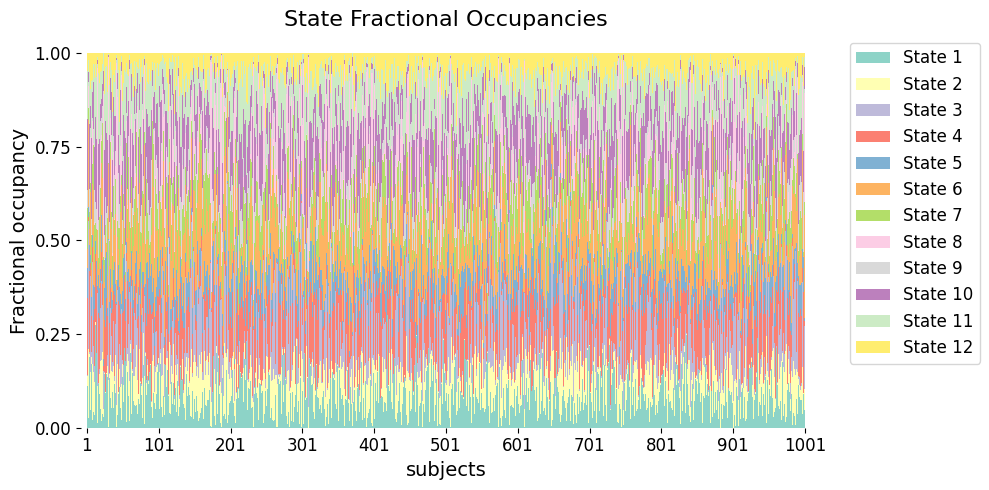

In [10]:
# Plot FO
graphics.plot_FO(D_fo, 
                 xlabel="subjects", 
                 width=1, 
                 figsize=(10,5),
                 save_path= PATH_FIGURES / "1_FO_HCP.pdf")

The plot reveals that the distribution of time spent in each state is relatively homogeneous across all subjects. This consistency highlights how the states are captured uniformly across the dataset, providing a strong basis for further analysis.

## Part 2 & 3. Statistical Analysis and Visualisation <a id="stat_analysis"></a>
### 6. Types of test - Across-subject test <a id="stat_test"></a>

With the `D_fo` matrix representing brain data ($D$) and the `R_data` containing behavioural measurements ($R$), we can now perform statistical tests to study their relationships using the function `test_across_subjects`.

**What is Permutation Testing**: Instead of assuming a specific data distribution, permutation testing assesses statistical significance by creating a "null distribution" in a non-parametric fashion. For this, it randomly shuffles the data to simulate a scenario where no relationship exists between the variables tested (the null hypothesis). For `test_across_subjects`, each observation corresponds to an individual subject. By comparing the original data's effect size with the null distribution, we can determine whether observed differences are statistically significant (the alternative hypothesis).

This process is visualised in **Figure 5A** from the [paper](https://www.biorxiv.org/content/10.1101/2023.01.03.522583v4):

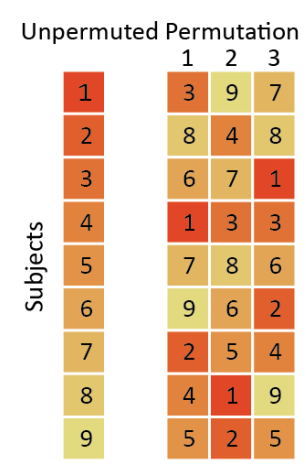

**A 9 x 4 matrix representing permutation testing across subjects**: Each row corresponds to a subject, with one observation each. The first column: displays the original index of each subject (perm=0). Next columns: examples of permuted subject indices.

#### Family Structure<a id="fam_struc"></a>
By default, the `test_across_subjects` function assumes that all subjects are exchangeable, meaning any two subjects can be swapped. However, some data sets real-world datasets (like the HCP) have familial relationships (or other type of relationships) that violate this exchangeability assumption.

To address this, we use an Exchangeability Block (EB) file (`EB.csv`). This file organises subjects into groups (e.g., families) and ensures that permutation testing respects these relationships by shuffling entire families collectively. For more details, refer to [Winkler et al, 2015](https://www.sciencedirect.com/science/article/pii/S105381191500508X?via%3Dihub).

A step-by-step tutorial on creating an `EB.csv` file for HCP data is available in the notebook [HCP_multi_level_block_permutation.ipynb](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/HCP_multi_level_block_permutation.ipynb).

When incorporating family structure into the `test_across_subjects` function, we specify a dictionary (`dict_fam`) to define the file location of the `EB.csv` file and include any optional parameters. Here’s an example setup with default options:

In [11]:
dict_fam = {
    'file_location': PATH_DATA / 'EB.csv',  # Specify the file location of the family structure data
                                # 'file_location': r'C:\Users\...\EB.csv'
}

### 7. Multivariate Test <a id="perm_multivariate"></a>

Building on the concept of permutation testing, the multivariate analysis evaluates whether variations in brain activity (`D_fo`, representing FO) are associated to differences in behavioural measurements (`R_data`, representing cognitive traits). This approach examines all brain states simultaneously, testing whether patterns in FO can explain variability in the behavioural data. For example, the analysis can test whether the distribution of time spent in specific brain states is significantly associated with differences in fluid intelligence across subjects.

---

##### Inputs and Settings

To perform the multivariate analysis using the `test_across_subjects` function, the following inputs and settings are defined:

**Inputs:**
- `D_data`: The state fractional occupancies (FO)
- `R_data`: The behavioural measurements across 15 cognitive traits
- `confounds_data` (optional): Confounding variables such as sex, age, and fMRI motion to control for external influences

**Settings:**
- `method = "multivariate"`: Specifies multivariate testing to examine relationships across all brain states
- `dict_fam` (optional): Includes family structure information to account for related participants
---

##### Running the Analysis

Here’s the code to perform the test:

In [ ]:
# Set parameters for multivariate testing
method = "multivariate"
Nnull_samples = 10_000  # Number of permutations
# Features of each behavioural variable
features = ['ReadEng_Unadj', 'PicVocab_Unadj', 'WM_Task_Acc', 'PMAT24_A_CR',
            'ListSort_Unadj', 'PMAT24_A_SI', 'PicSeq_Unadj', 'VSPLOT_TC', 
            'CardSort_Unadj', 'Language_Task_Acc', 'Flanker_Unadj', 'IWRD_TOT', 
            'ProcSpeed_Unadj', 'PMAT24_A_RTCR', 'MMSE_Score']


# Perform multivariate analysis
result_multivariate = statistics.test_across_subjects(
    D_data=D_fo,
    R_data=R_data,
    confounds=confounds_data,
    method=method,
    Nnull_samples=Nnull_samples,
    dict_family=dict_fam,
    outcome_names= features
)

Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


100%|██████████| 10000/10000 [00:30<00:00, 331.07it/s]


We can now examine the ```result_multivariate``` variable, which is a dictionary containing the results of a statistical analysis. Significant results indicate that the FO patterns contribute to explaining differences in behavioural measurements, while non-significant p-values do not provide evidence for the alternative hypothesis.


In detail, the output comprises the following fields:
* ```pval```: The p-values quantifying the statistical significance of the observed association, computed by comparing the observed test statistic to a reference distribution generated under the null hypothesis.

* ```base_statistics```:  The observed test statistic calculated from the original (unshuffled) data.

* ```null_stat_distribution```:  This list can store the test statistics across all permutatons, returned if ```test_statistic_option=True```. If set to `False` only the observed test statistic is returned.  These values are used to compute the empirical p-values.

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_subjects```

* ```method```: Specifies the analytical method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing

* ```test_combination``` Specifies whether p-values are combined. This can be done across rows (producing one p-value per row), across columns (producing one p-value per column), or into a single combined p-value for the entire matrix

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```performed_tests```: A dictionary that marks the columns in the test_statistics or p-value matrix corresponding to the (q dimension) where t-tests or F-tests have been performed

* ```Nnull_samples```: Is the number of permutations that has been performed

* ```test_summary```: A dictionary summarising the test results based on the applied method.

In [61]:
# Display summary statistics
statistics.display_test_summary(result_multivariate)


Model Summary:
          Outcome     R²  F-stat  df1  df2  p-value (R²)
    ReadEng_Unadj 0.0304  2.5874   12  989        0.0040
   PicVocab_Unadj 0.0242  2.0482   12  989        0.0241
      WM_Task_Acc 0.0352  3.0058   12  988        0.0005
      PMAT24_A_CR 0.0136  1.1315   12  985        0.2733
   ListSort_Unadj 0.0312  2.6543   12  989        0.0007
      PMAT24_A_SI 0.0104  0.8589   12  985        0.5105
     PicSeq_Unadj 0.0232  1.9546   12  989        0.0327
        VSPLOT_TC 0.0122  1.0176   12  986        0.4552
   CardSort_Unadj 0.0157  1.3122   12  987        0.1758
Language_Task_Acc 0.0391  3.3361   12  983        0.0001
    Flanker_Unadj 0.0160  1.3439   12  989        0.1611
         IWRD_TOT 0.0136  1.1299   12  986        0.2947
  ProcSpeed_Unadj 0.0181  1.5176   12  989        0.0963
    PMAT24_A_RTCR 0.0082  0.6766   12  985        0.7224
       MMSE_Score 0.0142  1.1887   12  989        0.2313

Coefficients Table:
Predictor           Outcome    T-stat  p-value     

#### 8. Multiple Comparison - Multivariate <a id="multi_corr"></a>
To reduce the risk of false positives (type I errors) in the multivariate test, we apply the Benjamini/Hochberg correction to the p-values from the `result_multivariate` output. Other methods for correction are available. 


In [62]:
# Multiple comparison
pval_multivariate_corrected, rejected_multivariate_corrected = statistics.pval_correction(
    result_multivariate, 
    method='fdr_bh'
)

#### 9. Visualisation of results  <a id="multi_vis"></a>
With both uncorrected and corrected p-values available, we can create visualisations using the `plot_p_values_bar` function.
We plot the uncorrected p-values alongside the corrected ones to observe the impact of the Benjamini/Hochberg correction:




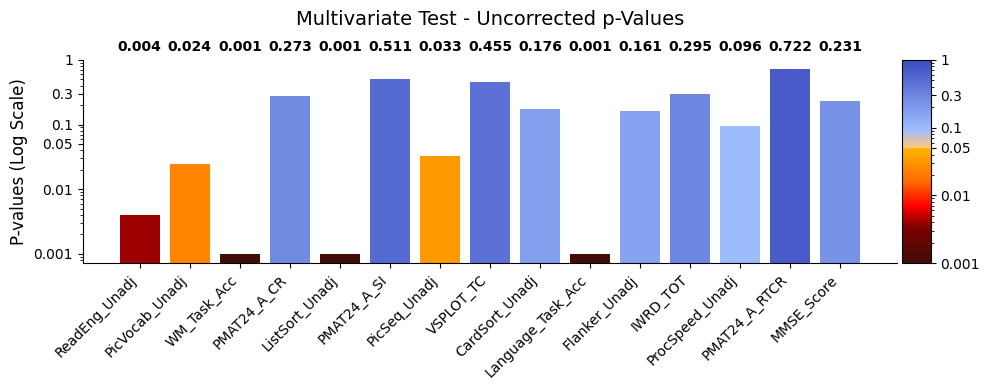

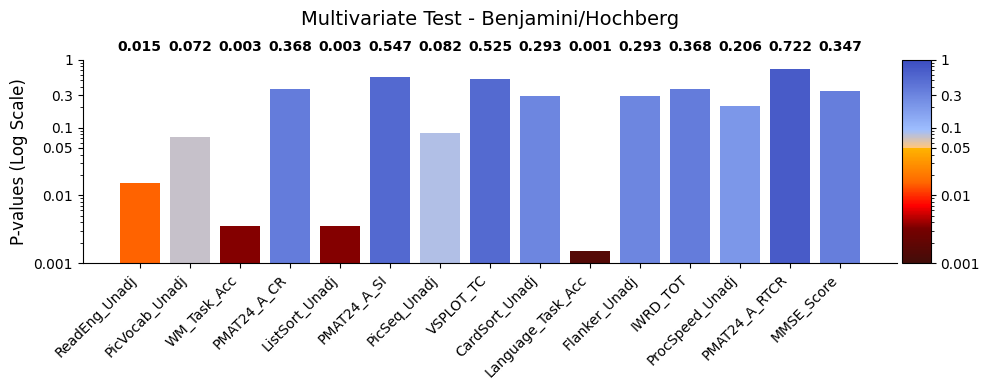

In [63]:
# Threshold for the p-value plots
alpha = 0.05
figsize = (10,4)
# Plot uncorrected p-values
graphics.plot_p_values_bar(
    result_multivariate["pval"], 
    title_text="Multivariate Test - Uncorrected p-Values", 
    figsize=figsize, 
    alpha=alpha, 
    xticklabels=features, 
    xlabel_rotation=45, 
    pval_text_height_same=True,
    save_path= PATH_FIGURES / "1_multi_uncorrected.pdf"
)

# Plot corrected p-values
graphics.plot_p_values_bar(
    pval_multivariate_corrected, 
    title_text="Multivariate Test - Benjamini/Hochberg", 
    figsize=figsize, 
    alpha=alpha, 
    xticklabels=features, 
    xlabel_rotation=45, 
    pval_text_height_same=True, 
    save_path= PATH_FIGURES / "1_multi_fdr_bh.pdf"
)



The multivariate test thus revealed significant associations between Fractional Occupancy (FO) and the following behavioural measurements after p-value correction:

* ReadEng_Unadj (NIH Toolbox Oral Reading Recognition Test: Unadjusted Scale Score),
* PicVocab_Unadj (NIH Toolbox Picture Vocabulary Test: Unadjusted Scale Score),
* WM_Task_Acc (Working Memory Task Overall Accuracy),
* Language_Task_Acc (Language Task Overall Accuracy).

These findings demonstrate that variations in brain state dynamics are related to cognitive performance, particularly in tasks related to language and working memory. Importantly, these associations remain significant even after controlling for confounds such as sex, age, and fMRI motion.

We can also visualise the distribution of base statistics under the null:



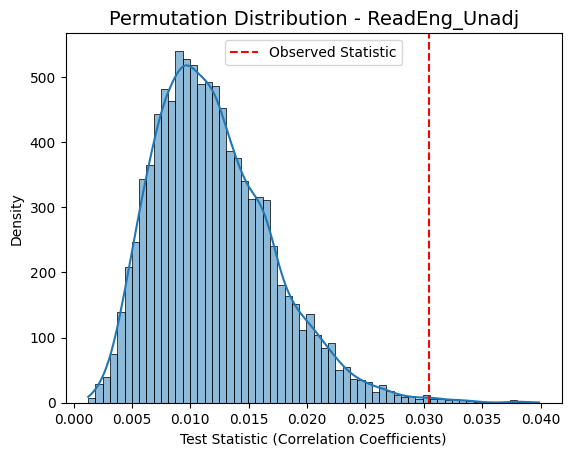

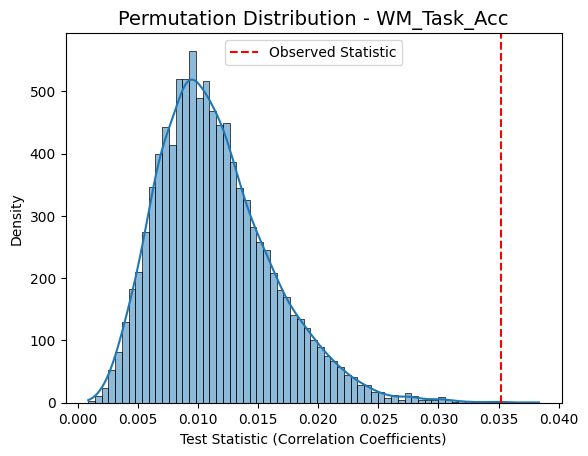

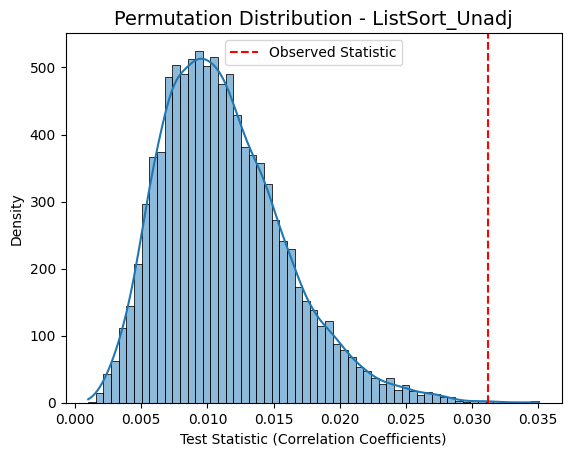

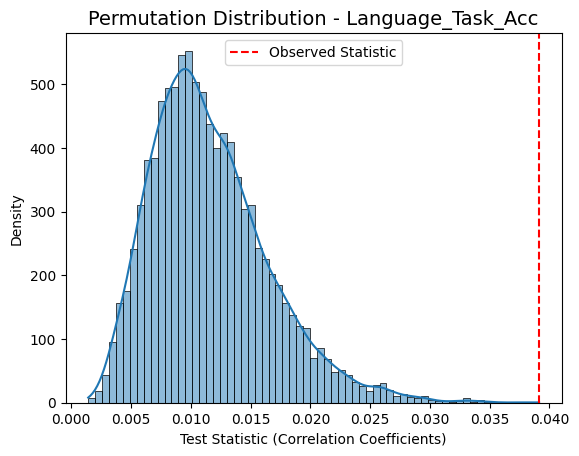

In [64]:
# Identify indices of significant features
significant_indices = np.where(pval_multivariate_corrected < alpha)

# Plot permutation distributions for significant features
xlabel = "Test Statistic (Correlation Coefficients)"
for idx in significant_indices[0]:
    graphics.plot_permutation_distribution(
        result_multivariate["test_statistics"][:, idx],
        title_text=f"Permutation Distribution - {features[idx]}",
        xlabel=xlabel,
        save_path= PATH_FIGURES / f"1_perm_dist_{features[idx]}.pdf"
    )

The histogram displays the permutation distribution for each test statistic, with the red line indicating the observed value.\
This helps illustrate how the observed results differ from the null distribution.


We can also perform FWER correction using the MaxT method directly, then there is no need to perform multiple comparison test after. or just run `statistics.pval_FWER_correction`

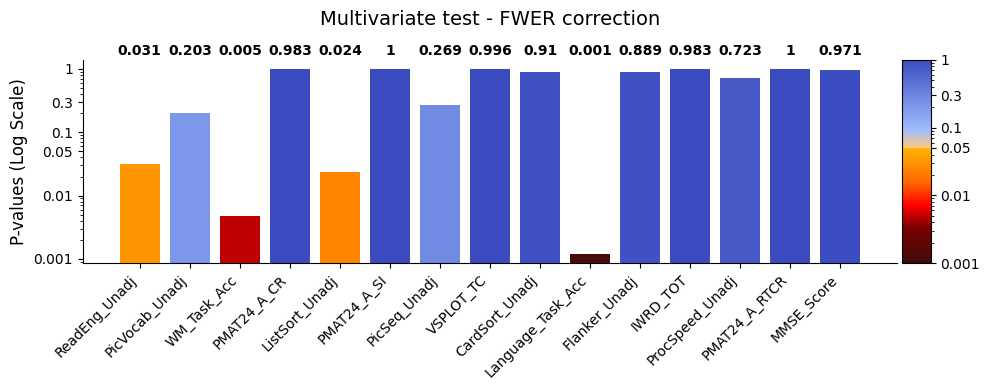

In [65]:
# Apply FWER
pval_multivariate_FWER =statistics.pval_FWER_correction(result_multivariate)

# Visualise results
graphics.plot_p_values_bar(
    pval_multivariate_FWER, 
    title_text ="Multivariate test - FWER correction",
    figsize=figsize, 
    alpha=0.05, 
    xticklabels=features,
    xlabel_rotation=45, 
    pval_text_height_same=True, 
    save_path= PATH_FIGURES / "1_multi_FWER.pdf"
)

### 7. Univariate Test <a id="perm_univariate"></a>
The univariate test examines one brain state (`D_fo`, FO) and one behavioural measurement (`R_data`) at a time to identify potential association between them. Unlike the multivariate test, which considers all brain states together, the univariate test isolates individual relationships to give a clearer view of specific connections.

- **Significant results**:  A brain state is associated to a behavioural trait 
- **Non-significant results**: No clear association is found between the brain state and the behaviour

---

#### Inputs and Settings
To perform the univaraiate analysis using the `test_across_subjects` function, the following inputs and settings are defined:

**Inputs:**
- `D_data`: Fractional Occupancies (FO)
- `R_data`: Behavioural measurements (one trait at a time)
- `confounds_data` (optional): Confounds (e.g., sex, age, motion)

**Settings:**
- `method = "univariate"`: Univariate pairwise testing
- `dict_fam` (optional): Family structure information

---

#### Running the Analysis
Here’s the code to perform the univariate analysis:

In [ ]:
# Set parameters
method = "univariate"
Nnull_samples = 10_000
test_statistics_option = True

# Perform univariate analysis
result_univariate = statistics.test_across_subjects(
    D_data=D_fo,
    R_data=R_data,
    confounds=confounds_data,
    method=method,
    Nnull_samples=Nnull_samples,
    dict_family=dict_fam,
)

Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


The output structure of `result_univariate` is the same as for the multivariate test and will not be repeated here.

#### 8. Multiple Comparison - Univariate <a id="uni_corr"></a>
To control for false positives in the univariate test, we apply Benjamini/Hochberg (BH) correction to the p-values. For other methods, have a look at the documentation.

In [67]:
# Multiple correction
pval_univariate_corrected, rejected_univariate_corrected = statistics.pval_correction(
    result_univariate, method='fdr_bh'
)

#### 9. Visualisation of results  <a id="uni_vis"></a>
With both uncorrected and corrected p-values, we can visualise the results:


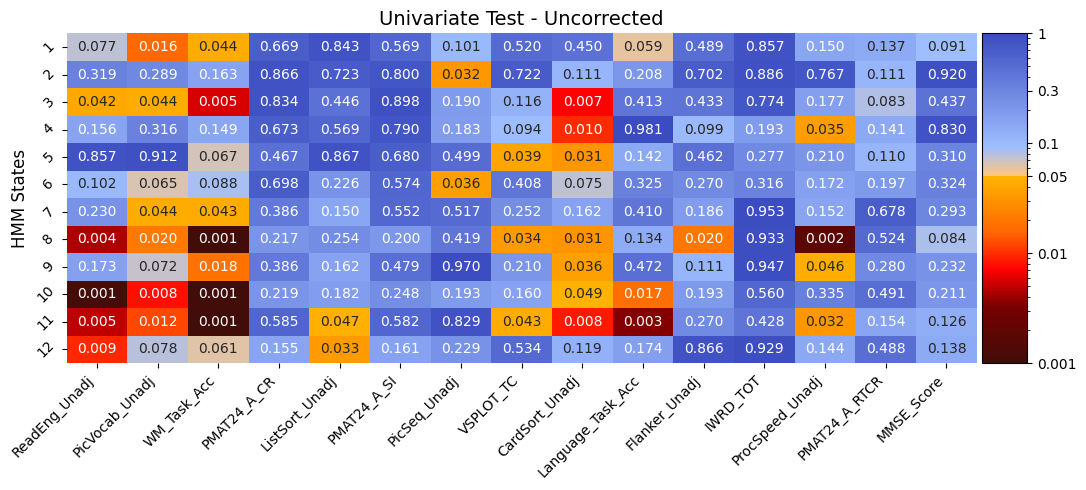

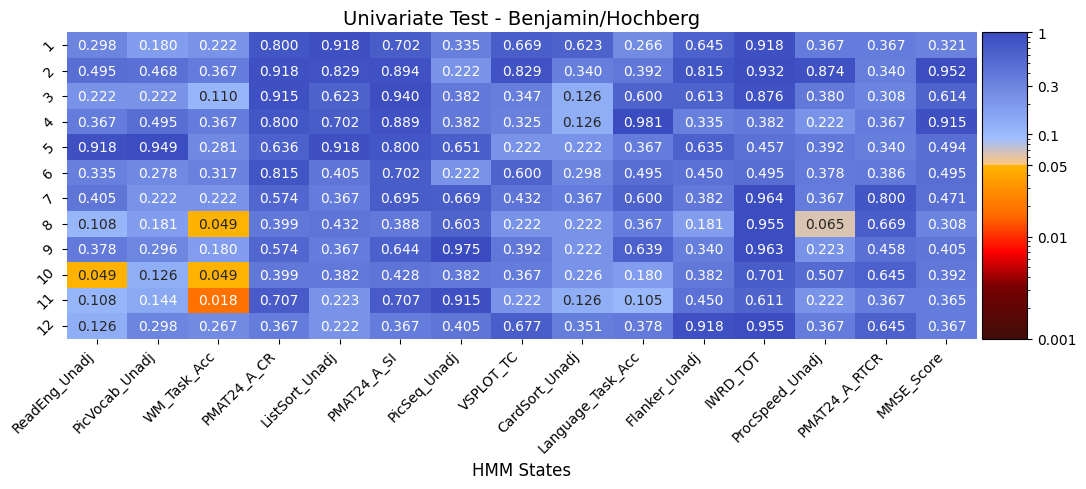

In [ ]:
# Uncorrected p-values
graphics.plot_p_value_matrix(
    result_univariate["pval"], 
    title_text="Univariate Test - Uncorrected",
    figsize=(11, 5), 
    ylabel="HMM States", 
    xticklabels=features, 
    alpha=alpha, 
    annot=True, 
    xlabel_rotation=45, 
    save_path= PATH_FIGURES / "1_uni_uncorrected.pdf"
)

# Corrected p-values
graphics.plot_p_value_matrix(
    pval_univariate_corrected, 
    title_text="Univariate Test - Benjamin/Hochberg",
    figsize=(11, 5), 
    xlabel="HMM States", 
    ylabel="", 
    annot=True, 
    xticklabels=features,
    xlabel_rotation=45, 
    save_path= PATH_FIGURES / "1_uni_fdr_bh.pdf"
)

**FWER Correction Option**

Alternatively, you can apply Family-Wise Error Rate (FWER) correction using the MaxT method during the univariate test, eliminating the need for separate multiple comparison adjustments:

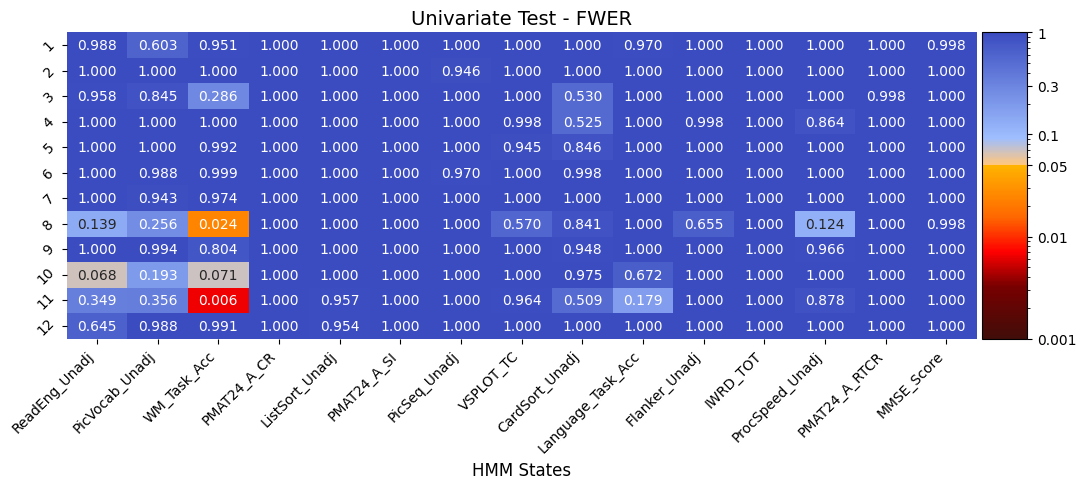

In [ ]:
# Correct for FWER
pval_univariate_FWER =statistics.pval_FWER_correction(result_univariate)

# Visualising the results
graphics.plot_p_value_matrix(
    pval_univariate_FWER, 
    title_text="Univariate Test - FWER",
    figsize=(11, 5), 
    xlabel="HMM States", 
    ylabel="", 
    annot=True, 
    xticklabels=features,
    xlabel_rotation=45, 
    save_path= PATH_FIGURES / "1_uni_FWER.pdf"
)

**Conclusion - Univariate test**

The univariate test showed that certain brain states are linked to cognitive traits before applying multiple comparison correction:

* `ReadEng_Unadj`: 6 different states
* `PicVocab_Unadj`: 7 different states
* `WM_Task_Acc`: 7 different states
* `ListSort_Unadj`: 1 state
* `PicSeq_Unadj`: 2 different states
* `VSPLOT_TC`: 2 different states
* `CardSort_Unadj`: 6 different states
* `Language_Task_Acc`: 2 different states
* `Flanker_Unadj`: 1 state
* `ProcSpeed_Unadj`: 2 different states

After correcting for multiple comparisons using the FWER only:

* `WM_Task_Acc`: 2 different states remained significant

This reduction highlights the conservative nature of FWER, which minimises false positives but may also overlook possibly real effects.

The **multivariate test**, which looks at how all brain states work together, found significant results for`ReadEng_Unadj`, `PicVocab_Unadj`, `WM_Task_Acc`, and `Language_Task_Acc`, even after corrections. This suggests that these cognitive traits may depend on combined patterns of brain activity rather than contributions from individual states.